In [29]:
# Code Author: Yashwanth Ravipati , not permitted to use without explicit permission. 
# import the needed libraries first
import os
import cv2
import tensorflow as tf
from os.path import exists
from keras.models import Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from pathlib import Path
import numpy as np
import shutil
import os

In [67]:
# initiatlize the global parameters
 
# path to source directory
src_dir = 'Desktop/AVCS/Train6/'
test_dir = 'Desktop/AVCS/Test6/'
number_of_classes = 6
number_of_epochs = 50
model_path='Desktop/AVCS/tl_model_v1.weights.best.hdf9'

list_dir = os.listdir(src_dir)
t_list_dir = os.listdir(test_dir)


['Patrol-Vessel', 'Cruise-Ship', 'Fishing-Vessel', 'Tanker', 'Cargo-Ship', 'Combat-Vessel']
['Patrol-Vessel', 'Cruise-Ship', 'Fishing-Vessel', 'Tanker', 'Cargo-Ship', 'Combat-Vessel']


# Training the Base Model

In [68]:
#Prepare training & validation data for model training

#first set up the ImageDataGenerator
train_generator = ImageDataGenerator(
    rescale=1/255.,              # normalize pixel values between 0-1
    brightness_range=[0.1, 0.7], # specify the range in which to decrease/increase brightness
    width_shift_range=0.5,       # shift the width of the image 50%
    rotation_range=30,           # random rotation by 45 degrees
    horizontal_flip=True,        # 180 degree flip horizontally
    vertical_flip=True,          # 180 degree flip vertically
    validation_split=0.15        # 15% of the data will be used for validation at end of each epoch
)
# Limit the classes for training if need to be. Comment the below lines to train all the available classification of vessels 
class_subset = sorted(os.listdir(src_dir))[:6]
class_subset1 = sorted(os.listdir(src_dir))[:6]
BATCH_SIZE = 32
# Create Train dataset, set image size to 224 x 224 to match up VGG16
traingen = train_generator.flow_from_directory(src_dir,
                                               target_size=(224, 224),
                                               batch_size=BATCH_SIZE,
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='training',
                                               shuffle=True,
                                               seed=42)
#Create the validation dataset
validgen = train_generator.flow_from_directory(src_dir,
                                               target_size=(224, 224),
                                               batch_size=BATCH_SIZE,
                                               class_mode='categorical',
                                               classes=class_subset1,
                                               subset='validation',
                                               shuffle=True,
                                               seed=42)

Found 4695 images belonging to 6 classes.
Found 824 images belonging to 6 classes.


In [69]:
# Define create model method with fine tuning options

def create_model(input_shape, n_classes, fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    conv_base.summary()
    
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    #top_model = Dense(4096, activation='relu')(top_model)
    #top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dense(256, activation='relu')(top_model)
    top_model = Dense(128, activation='relu')(top_model)
    top_model = Dense(64, activation='relu')(top_model)
    top_model = Dense(32, activation='relu')(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer='Adam', 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [ ]:


# Impoet needed classes 
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard


# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath=model_path,
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

#from keras.optimizers import Adam
input_shape = (224, 224, 3)
#optim_1 = Adam(learning_rate=0.001)
n_classes= number_of_classes

n_steps = traingen.samples // BATCH_SIZE
#n_val_steps = validgen.samples // BATCH_SIZE
n_epochs = number_of_epochs

# We'll train the model with Fine-tuning
vgg_model = create_model(input_shape, n_classes, fine_tune=2)

#%%time 
from keras.callbacks import ModelCheckpoint, EarlyStopping
vgg_history = vgg_model.fit(traingen,
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            validation_data=validgen,
                            steps_per_epoch=n_steps,
                           # validation_split=0.20,
                            callbacks=[tl_checkpoint_1, early_stop],
                            verbose=1)

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Found 502 images belonging to 6 classes.
Overall Categorical Accuracy: 77.89%


,Precision,Recall,F-Score,Support
Cruise-Ship,0.881356,0.866667,0.873950,60.0
Cargo-Ship,0.790698,0.971429,0.871795,105.0
Patrol-Vessel,0.610169,0.986301,0.753927,73.0
Combat-Vessel,0.951220,0.619048,0.750000,63.0
Fishing-Vessel,0.744898,0.752577,0.748718,97.0
Tanker,0.929825,0.509615,0.658385,104.0


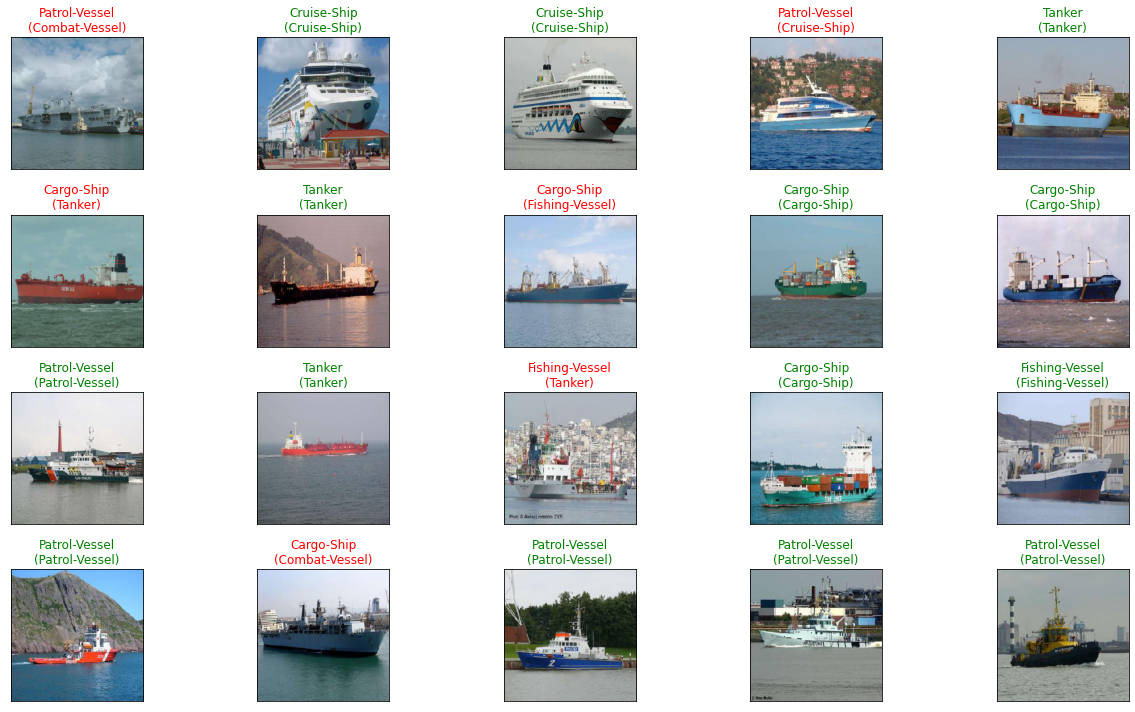

In [62]:
# Test the model by feeding test dataset, compare predicted model results with actuals
test_generator = ImageDataGenerator(rescale=1/255.)

testgen = test_generator.flow_from_directory(test_dir,
                                             target_size=(224, 224),
                                             batch_size=1,
                                             class_mode=None,
                                             classes=class_subset,
                                
                                             shuffle=False,
                                             seed=42)

#predicted_classes = vgg_model.predict_classes(testgen)
result = vgg_model.predict(testgen)
#d=image.load_img(path)
#plt.imshow(d)
predicted_classes=np.argmax(result,axis=1)

class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())
true_classes = testgen.classes

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# plot the key metrics 
def display_results(y_true, y_preds, class_labels):
    
    results = pd.DataFrame(precision_recall_fscore_support(y_true, y_preds),
                          columns=class_labels).T

    results.rename(columns={0: 'Precision', 1: 'Recall',
                            2: 'F-Score', 3: 'Support'}, inplace=True)
    
    results.sort_values(by='F-Score', ascending=False, inplace=True)                           
    global_acc = accuracy_score(y_true, y_preds)
    
    print("Overall Categorical Accuracy: {:.2f}%".format(global_acc*100))
    return results
# plot the sample subset of predictions, Use green to denote correct classification and red to denote incorrect classification
def plot_predictions(y_true, y_preds, test_generator, class_indices):

    fig = plt.figure(figsize=(20, 10))
    for i, idx in enumerate(np.random.choice(test_generator.samples, size=20, replace=False)):
        ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(test_generator[idx]))
        pred_idx = y_preds[idx]
        true_idx = y_true[idx]
                
        plt.tight_layout()
        ax.set_title("{}\n({})".format(class_indices[pred_idx], class_indices[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))
# Plot key         
plot_predictions(true_classes, predicted_classes, testgen, class_indices)
display_results(true_classes, predicted_classes, class_indices.values())

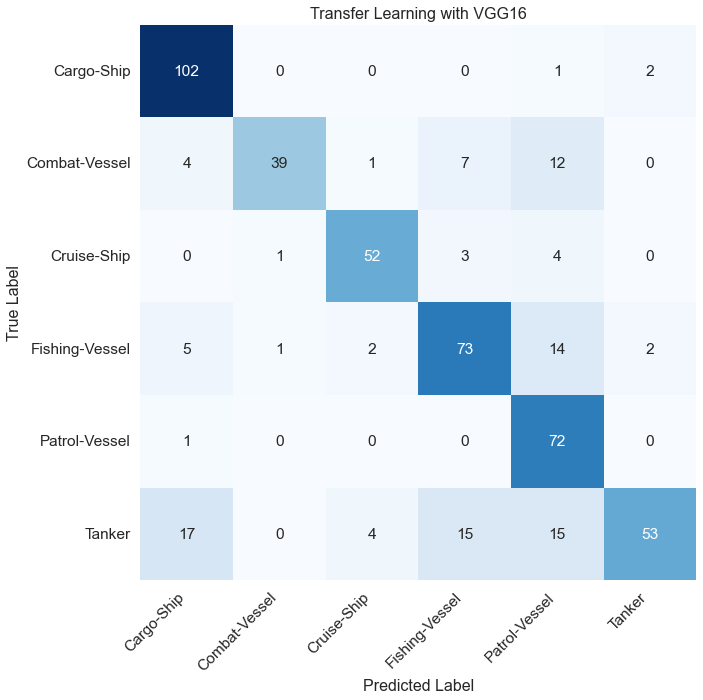

In [66]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the names of the ten classes
class_names = testgen.class_indices.keys()
# Generaye the confusion matrix
def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.set(font_scale=1.3)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_ylabel('True Label', fontsize=16)
    ax.set_xlabel('Predicted Label', fontsize=16)
    
#fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
fig, (ax3) = plt.subplots(1, 1, figsize=(20, 10))

plot_heatmap(true_classes, predicted_classes, class_names, ax3, title="Transfer Learning with VGG16")    

#fig.suptitle("Confusion Matrix Model Comparison", fontsize=24)
fig.tight_layout()

plt.show()

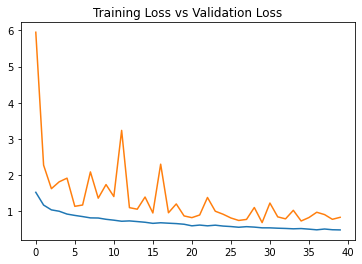

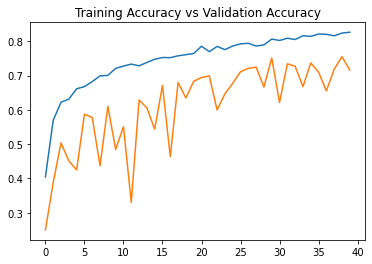

In [60]:
# Plot the loss and accuracy curves
import matplotlib.pyplot as plt
plt.title('Training Loss vs Validation Loss')
plt.plot(vgg_history.history['loss'])
plt.plot(vgg_history.history['val_loss'])
plt.show()
import matplotlib.pyplot as plt
plt.title('Training Accuracy vs Validation Accuracy')
plt.plot(vgg_history.history['accuracy'])
plt.plot(vgg_history.history['val_accuracy'])
plt.show()